In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import pandas as pd
from adjustText import adjust_text
import random
from model_structure import get_preprocessing_transforms,BCNN, train_model, evaluate_model

In [2]:
INPUT_SIZE = 224
BATCH_SIZE = 32
DEVICE =torch.device('cuda' if torch.cuda.is_available() else 'cpu')#torch.device('cpu')

In [3]:
def read_data():
    # Get transforms
    train_transform, val_transform = get_preprocessing_transforms(INPUT_SIZE)

    test_data_1_dir = 'data4model_1/test/'
    test_data_2_dir = 'data4model_2/test/'
    train_data_1_dir = 'data4model_1/train/'
    train_data_2_dir = 'data4model_2/train/'

    # Load data set
    dataset_test_1 = datasets.ImageFolder(test_data_1_dir,transform=val_transform)
    dataset_train_1 = datasets.ImageFolder(train_data_1_dir,transform=train_transform)
    dataset_test_2 = datasets.ImageFolder(test_data_2_dir,transform=val_transform)
    dataset_train_2 = datasets.ImageFolder(train_data_2_dir,transform=train_transform)

    test_loader_1 = DataLoader(dataset_test_1, shuffle=False, batch_size=BATCH_SIZE)
    train_loader_1 = DataLoader(dataset_train_1, shuffle=False, batch_size=BATCH_SIZE)
    test_loader_2 = DataLoader(dataset_test_2, shuffle=False, batch_size=BATCH_SIZE)
    train_loader_2 = DataLoader(dataset_train_2, shuffle=False, batch_size=BATCH_SIZE)

    return {"Model_1:Train": train_loader_1,
            "Model_1:Test": test_loader_1,
            "Model_2:Train": train_loader_2,
            "Model_2:Test": test_loader_2}

In [4]:
model_1_dir = 'best_model_1.pth'
model_2_dir = 'best_model_2.pth'

In [5]:
# Load the model
model_1 = BCNN().to(DEVICE)
weights = torch.load(model_1_dir, map_location=torch.device(DEVICE))
model_1.load_state_dict(weights)
model_1.eval()

model_2 = BCNN().to(DEVICE)
weights = torch.load(model_2_dir, map_location=torch.device(DEVICE))
model_2.load_state_dict(weights)
model_2.eval()

C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1438434258.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(model_1_dir, map_location=torch.device(

BCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): Sigm

In [6]:
dataSets = read_data()

In [7]:
for key in dataSets:
    print(key)
    if "Model_1" in key:
        model = model_1
    else:
        model = model_2
    
    results = evaluate_model(model.to(DEVICE), dataSets[key], DEVICE)
    print("Accuracy: ", results[0])
    print("F1 Score: ", results[1])
    print("confusion Matrix: \n",results[3])
    print("\n")

Model_1:Train
Accuracy:  0.9156666666666666
F1 Score:  0.915356306457009
confusion Matrix: 
 [[1379  121]
 [ 132 1368]]


Model_1:Test
Accuracy:  0.7262644728823888
F1 Score:  0.741422979507253
confusion Matrix: 
 [[2739 1361]
 [ 885 3220]]


Model_2:Train
Accuracy:  0.897
F1 Score:  0.8952897322941376
confusion Matrix: 
 [[1370  130]
 [ 179 1321]]


Model_2:Test
Accuracy:  0.905
F1 Score:  0.9090909090909091
confusion Matrix: 
 [[86 14]
 [ 5 95]]




In [7]:
activation_values = {"Model_1":{},
                        "Model_2":{}}

In [ ]:
def get_activation(name,model_name):
    def hook(model, input, output):
        activation_values[model_name][name] = output.detach()
    return hook

def register_hooks(model,model_name):
    hooks = []
    layer_info = {}
    counter = 0
    for name, layer in model.named_modules():
        #if isinstance(layer, (nn.Conv2d, nn.Linear)):
            # Register hook for the full layer output
            hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            
            if isinstance(layer, nn.Linear) and False:
                layer_info[name] = {'type': f'{counter}-linear',}
                hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            elif isinstance(layer, nn.Conv2d) and False:
                layer_info[name] = {'type': f'{counter}-conv'}
                hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            # elif isinstance(layer, nn.ReLU):
            #      layer_info[name] = {'type': f'{counter}-relu'}
            #      hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            # elif isinstance(layer, nn.MaxPool2d):
            #     layer_info[name] = {'type': f'{counter}-maxpool'}
            # elif isinstance(layer, nn.Dropout):
            #     layer_info[name] = {'type': f'{counter}-dropout'}
            # elif isinstance(layer, nn.Flatten):
            #     layer_info[name] = {'type': f'{counter}-flatten'}
            elif isinstance(layer, nn.Softmax):
                layer_info[name] = {'type': f'{counter}-softmax'}
            # else:
            #     layer_info[name] = {'type': f'{counter}-other'}
            counter += 1
    return hooks, layer_info


def analyze_positive_activations(activations1, activations2,layers1,layers2, pic_index, model1_name="Model 1", model2_name="Model 2",
                                     image=None,  
                                    pred1=None,  
                                    pred2=None):
    def get_layer_stats(activations, layers):
        layer_stats = {}
        for layer_name, layer_data in layers.items():
            activation = activations[layer_name]
            flattened = activation.view(activation.shape[0], -1)
            positive_activations = flattened[flattened > 0]
            
            stats = {
                'count': len(positive_activations),
                'total_neurons': flattened.numel(),
                'percentage_active': (len(positive_activations) / flattened.numel()) * 100,
                'mean': positive_activations.mean().item() if len(positive_activations) > 0 else 0,
                'sum': positive_activations.sum().item(),
                'max': positive_activations.max().item() if len(positive_activations) > 0 else 0,
                'min': positive_activations.min().item() if len(positive_activations) > 0 else 0,
                'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
            }
            layer_stats[layer_name.split(".")[0]+" "+layers[layer_name]["type"]] = stats
        return layer_stats

    # Get stats for both models
    stats1 = get_layer_stats(activations1,layers1)
    stats2 = get_layer_stats(activations2,layers2)

    # Create combined DataFrame
    combined_stats = {}
    for layer_name in stats1.keys():
        combined_stats[layer_name] = {
            f'data_index':pic_index,
            f'count_{model1_name}': stats1[layer_name]['count'],
            f'count_{model2_name}': stats2[layer_name]['count'],
            f'total_neurons_{model1_name}': stats1[layer_name]['total_neurons'],
            f'total_neurons_{model2_name}': stats2[layer_name]['total_neurons'],
            f'percentage_active_{model1_name}': stats1[layer_name]['percentage_active'],
            f'percentage_active_{model2_name}': stats2[layer_name]['percentage_active'],
            f'mean_{model1_name}': stats1[layer_name]['mean'],
            f'mean_{model2_name}': stats2[layer_name]['mean'],
            f'sum_{model1_name}': stats1[layer_name]['sum'],
            f'sum_{model2_name}': stats2[layer_name]['sum'],
            f'max_{model1_name}': stats1[layer_name]['max'],
            f'max_{model2_name}': stats2[layer_name]['max'],
            f'min_{model1_name}': stats1[layer_name]['min'],
            f'min_{model2_name}': stats2[layer_name]['min'],
            f'variance_{model1_name}': stats1[layer_name]['variance'],
            f'variance_{model2_name}': stats2[layer_name]['variance']
        }

    df_combined = pd.DataFrame.from_dict(combined_stats, orient='index')
    
    return df_combined




In [11]:
with torch.no_grad():
    images = [(img, idx) for idx, (img, label) in enumerate(dataSets["Model_1:Test"].dataset) 
                if label == 0 and model_1(img.unsqueeze(0).to(DEVICE)).to("cpu").numpy()[0,0] < 0.5]

all_dfs = []

for image, pic_index in images:
    activation_values = {"Model_1":{},
                        "Model_2":{}}

    hooks1, layers1 = register_hooks(model_1, "Model_1")
    hooks2, layers2 = register_hooks(model_2, "Model_2")

    with torch.no_grad():
        pred1 = model_1(image.unsqueeze(0).to(DEVICE))
        pred2 = model_2(image.unsqueeze(0).to(DEVICE))
        

    df_combined = analyze_positive_activations(
        activation_values["Model_1"], 
        activation_values["Model_2"],
        layers1,
        layers2,
        pic_index,
        "Model_1",
        "Model_2",
        image,
        pred1,
        pred2
    )

    # Add image index as a column
    df_combined['image_index'] = pic_index
    
    # Add to list
    all_dfs.append(df_combined)
    print("pic_index: ", pic_index)

    # Remove hooks
    for hook in hooks1 + hooks2:
        hook.remove()

C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  0
pic_index:  1
pic_index:  2


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  4
pic_index:  5
pic_index:  7
pic_index:  8
pic_index:  9
pic_index:  11
pic_index:  12
pic_index:  14
pic_index:  16
pic_index:  17
pic_index:  18
pic_index:  19
pic_index:  20
pic_index:  21
pic_index:  22
pic_index:  24
pic_index:  25
pic_index:  26
pic_index:  27
pic_index:  28
pic_index:  29
pic_index:  30
pic_index:  32
pic_index:  34
pic_index:  35
pic_index:  39
pic_index:  42
pic_index:  45


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  46
pic_index:  47
pic_index:  48
pic_index:  49
pic_index:  50
pic_index:  51
pic_index:  52
pic_index:  53
pic_index:  54
pic_index:  56
pic_index:  59
pic_index:  61
pic_index:  62
pic_index:  63
pic_index:  64
pic_index:  65
pic_index:  66


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  67
pic_index:  68
pic_index:  69
pic_index:  72
pic_index:  73
pic_index:  74
pic_index:  75
pic_index:  77
pic_index:  79
pic_index:  80
pic_index:  81
pic_index:  82
pic_index:  85
pic_index:  86
pic_index:  87
pic_index:  89
pic_index:  91
pic_index:  93
pic_index:  94
pic_index:  95
pic_index:  96
pic_index:  97
pic_index:  98
pic_index:  99
pic_index:  100
pic_index:  101
pic_index:  103
pic_index:  104
pic_index:  105
pic_index:  106
pic_index:  107
pic_index:  109
pic_index:  110
pic_index:  113
pic_index:  114


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  115
pic_index:  117
pic_index:  118
pic_index:  119
pic_index:  120
pic_index:  121
pic_index:  123
pic_index:  126
pic_index:  127
pic_index:  129
pic_index:  131
pic_index:  132
pic_index:  133
pic_index:  134
pic_index:  135
pic_index:  136
pic_index:  137
pic_index:  140


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  141
pic_index:  142
pic_index:  144
pic_index:  145
pic_index:  146
pic_index:  148
pic_index:  149
pic_index:  150
pic_index:  151
pic_index:  152
pic_index:  153
pic_index:  154
pic_index:  155
pic_index:  157
pic_index:  158
pic_index:  159
pic_index:  160
pic_index:  161
pic_index:  162
pic_index:  165
pic_index:  166
pic_index:  168
pic_index:  169
pic_index:  170
pic_index:  172
pic_index:  173
pic_index:  174
pic_index:  175
pic_index:  178
pic_index:  182
pic_index:  184


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  186
pic_index:  187
pic_index:  188
pic_index:  189
pic_index:  190
pic_index:  191
pic_index:  192
pic_index:  193
pic_index:  194
pic_index:  195
pic_index:  196
pic_index:  197
pic_index:  198
pic_index:  199
pic_index:  201
pic_index:  202
pic_index:  203
pic_index:  205
pic_index:  206


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  207
pic_index:  209
pic_index:  210
pic_index:  211
pic_index:  213
pic_index:  214
pic_index:  216
pic_index:  217
pic_index:  219
pic_index:  220
pic_index:  221
pic_index:  222
pic_index:  223
pic_index:  226
pic_index:  228
pic_index:  229
pic_index:  231
pic_index:  234


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  236
pic_index:  237
pic_index:  238
pic_index:  239
pic_index:  240
pic_index:  241
pic_index:  242
pic_index:  245
pic_index:  246
pic_index:  248
pic_index:  250
pic_index:  251
pic_index:  252


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  253
pic_index:  254
pic_index:  255
pic_index:  256
pic_index:  258
pic_index:  260
pic_index:  262
pic_index:  263
pic_index:  264
pic_index:  265
pic_index:  266
pic_index:  269
pic_index:  270
pic_index:  271
pic_index:  272
pic_index:  273


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  274
pic_index:  276
pic_index:  277
pic_index:  284
pic_index:  287
pic_index:  288
pic_index:  292
pic_index:  293
pic_index:  298
pic_index:  301
pic_index:  302
pic_index:  304
pic_index:  305
pic_index:  306
pic_index:  310
pic_index:  311
pic_index:  312


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  314
pic_index:  316
pic_index:  317
pic_index:  318
pic_index:  320
pic_index:  322
pic_index:  323
pic_index:  324
pic_index:  325
pic_index:  327
pic_index:  328
pic_index:  329
pic_index:  331
pic_index:  332
pic_index:  333
pic_index:  335
pic_index:  336
pic_index:  337
pic_index:  339
pic_index:  340
pic_index:  342
pic_index:  343
pic_index:  344
pic_index:  346
pic_index:  347
pic_index:  348
pic_index:  350
pic_index:  353
pic_index:  354
pic_index:  355
pic_index:  357
pic_index:  358
pic_index:  359
pic_index:  360
pic_index:  361
pic_index:  362


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  363
pic_index:  364
pic_index:  366
pic_index:  367
pic_index:  368
pic_index:  373
pic_index:  374
pic_index:  377
pic_index:  378
pic_index:  379
pic_index:  380
pic_index:  381
pic_index:  383
pic_index:  385
pic_index:  386
pic_index:  387
pic_index:  388
pic_index:  389


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  393
pic_index:  394
pic_index:  396
pic_index:  397
pic_index:  398
pic_index:  399
pic_index:  400
pic_index:  401
pic_index:  402
pic_index:  406
pic_index:  407
pic_index:  408
pic_index:  409
pic_index:  410
pic_index:  411


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  412
pic_index:  414
pic_index:  415
pic_index:  416
pic_index:  417
pic_index:  419
pic_index:  420
pic_index:  421
pic_index:  422
pic_index:  423
pic_index:  425
pic_index:  426
pic_index:  427
pic_index:  428
pic_index:  429
pic_index:  430
pic_index:  431


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  433
pic_index:  435
pic_index:  436
pic_index:  437
pic_index:  438
pic_index:  440
pic_index:  441
pic_index:  443
pic_index:  444
pic_index:  446
pic_index:  447
pic_index:  448
pic_index:  449
pic_index:  451
pic_index:  452
pic_index:  453
pic_index:  456


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  457
pic_index:  458
pic_index:  460
pic_index:  461
pic_index:  466
pic_index:  467
pic_index:  472
pic_index:  473
pic_index:  474
pic_index:  475
pic_index:  477
pic_index:  479
pic_index:  480
pic_index:  481
pic_index:  482
pic_index:  483


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  485
pic_index:  486
pic_index:  487
pic_index:  488
pic_index:  489
pic_index:  491
pic_index:  492
pic_index:  493
pic_index:  494
pic_index:  496
pic_index:  497
pic_index:  498
pic_index:  499
pic_index:  500
pic_index:  501
pic_index:  502


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  504
pic_index:  505
pic_index:  506
pic_index:  507
pic_index:  512
pic_index:  513
pic_index:  514
pic_index:  515
pic_index:  516
pic_index:  518
pic_index:  520
pic_index:  521
pic_index:  523
pic_index:  524
pic_index:  526
pic_index:  528
pic_index:  531


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  532
pic_index:  533
pic_index:  534
pic_index:  535
pic_index:  537
pic_index:  538
pic_index:  539
pic_index:  540
pic_index:  543
pic_index:  544
pic_index:  546
pic_index:  547
pic_index:  548
pic_index:  549
pic_index:  550
pic_index:  552
pic_index:  553


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  555
pic_index:  556
pic_index:  557
pic_index:  558
pic_index:  560
pic_index:  561
pic_index:  562
pic_index:  563
pic_index:  564
pic_index:  566
pic_index:  567
pic_index:  568
pic_index:  569
pic_index:  570
pic_index:  572
pic_index:  573


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  575
pic_index:  576
pic_index:  577
pic_index:  578
pic_index:  579
pic_index:  580
pic_index:  581
pic_index:  583
pic_index:  586
pic_index:  587
pic_index:  588
pic_index:  591
pic_index:  593
pic_index:  594
pic_index:  595
pic_index:  596
pic_index:  597
pic_index:  599
pic_index:  601
pic_index:  602
pic_index:  603
pic_index:  605
pic_index:  607
pic_index:  610
pic_index:  611
pic_index:  613
pic_index:  614
pic_index:  616
pic_index:  617
pic_index:  619
pic_index:  620
pic_index:  621
pic_index:  623


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  625
pic_index:  628
pic_index:  629
pic_index:  630
pic_index:  635
pic_index:  636
pic_index:  638
pic_index:  639
pic_index:  641
pic_index:  642
pic_index:  643
pic_index:  644
pic_index:  645
pic_index:  646
pic_index:  648


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  652
pic_index:  653
pic_index:  654
pic_index:  656
pic_index:  657
pic_index:  658
pic_index:  661
pic_index:  663
pic_index:  664
pic_index:  665
pic_index:  667
pic_index:  668
pic_index:  670
pic_index:  672
pic_index:  675
pic_index:  676
pic_index:  678


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  679
pic_index:  680
pic_index:  681
pic_index:  682
pic_index:  684
pic_index:  685
pic_index:  687
pic_index:  690
pic_index:  692
pic_index:  695
pic_index:  696
pic_index:  699
pic_index:  700
pic_index:  701
pic_index:  702
pic_index:  704
pic_index:  706
pic_index:  707
pic_index:  708
pic_index:  710
pic_index:  711
pic_index:  715
pic_index:  716
pic_index:  717
pic_index:  718
pic_index:  720
pic_index:  723
pic_index:  724
pic_index:  725
pic_index:  726
pic_index:  727
pic_index:  733
pic_index:  735
pic_index:  737
pic_index:  738
pic_index:  740


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  741
pic_index:  742
pic_index:  743
pic_index:  745
pic_index:  746
pic_index:  747
pic_index:  749
pic_index:  751
pic_index:  753
pic_index:  755
pic_index:  757
pic_index:  758
pic_index:  760
pic_index:  761
pic_index:  762
pic_index:  763


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  766
pic_index:  769
pic_index:  770
pic_index:  773
pic_index:  774
pic_index:  775
pic_index:  777
pic_index:  778
pic_index:  779
pic_index:  780
pic_index:  781
pic_index:  783
pic_index:  784
pic_index:  785
pic_index:  786
pic_index:  788
pic_index:  790
pic_index:  791
pic_index:  794
pic_index:  795
pic_index:  796
pic_index:  797
pic_index:  798
pic_index:  799
pic_index:  800
pic_index:  803
pic_index:  804
pic_index:  806
pic_index:  807
pic_index:  809
pic_index:  813
pic_index:  815
pic_index:  816


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  818
pic_index:  819
pic_index:  820
pic_index:  821
pic_index:  823
pic_index:  824
pic_index:  826
pic_index:  827
pic_index:  828
pic_index:  829
pic_index:  830
pic_index:  831
pic_index:  833
pic_index:  834
pic_index:  836
pic_index:  838
pic_index:  839
pic_index:  840
pic_index:  841
pic_index:  842
pic_index:  844
pic_index:  845
pic_index:  851
pic_index:  853
pic_index:  855
pic_index:  856
pic_index:  858
pic_index:  859
pic_index:  861
pic_index:  862
pic_index:  863


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  864
pic_index:  865
pic_index:  869
pic_index:  871
pic_index:  872
pic_index:  875
pic_index:  876
pic_index:  877
pic_index:  878
pic_index:  879
pic_index:  880
pic_index:  881
pic_index:  882
pic_index:  884
pic_index:  887
pic_index:  888


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  889
pic_index:  890
pic_index:  891
pic_index:  892
pic_index:  894
pic_index:  897
pic_index:  899
pic_index:  900
pic_index:  901
pic_index:  902
pic_index:  903
pic_index:  904
pic_index:  905
pic_index:  908
pic_index:  909


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  910
pic_index:  911
pic_index:  914
pic_index:  916
pic_index:  917
pic_index:  919
pic_index:  922
pic_index:  923
pic_index:  928
pic_index:  929
pic_index:  931
pic_index:  932
pic_index:  933
pic_index:  934
pic_index:  935
pic_index:  936
pic_index:  937


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  938
pic_index:  940
pic_index:  942
pic_index:  943
pic_index:  944
pic_index:  946
pic_index:  950
pic_index:  951
pic_index:  952
pic_index:  953
pic_index:  954
pic_index:  955
pic_index:  956
pic_index:  957
pic_index:  958
pic_index:  959
pic_index:  960
pic_index:  961
pic_index:  962


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  963
pic_index:  965
pic_index:  969
pic_index:  970
pic_index:  971
pic_index:  972
pic_index:  973
pic_index:  974
pic_index:  977
pic_index:  978
pic_index:  980
pic_index:  981
pic_index:  982
pic_index:  984
pic_index:  985
pic_index:  986
pic_index:  987
pic_index:  988
pic_index:  989
pic_index:  990
pic_index:  991
pic_index:  992
pic_index:  993
pic_index:  994
pic_index:  995
pic_index:  996
pic_index:  997
pic_index:  998
pic_index:  999
pic_index:  1000


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1001
pic_index:  1002
pic_index:  1004
pic_index:  1007
pic_index:  1008
pic_index:  1011
pic_index:  1012
pic_index:  1013
pic_index:  1014
pic_index:  1016
pic_index:  1017
pic_index:  1018
pic_index:  1020
pic_index:  1021
pic_index:  1022
pic_index:  1025


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1026
pic_index:  1027
pic_index:  1029
pic_index:  1033
pic_index:  1035
pic_index:  1038
pic_index:  1039
pic_index:  1040
pic_index:  1042
pic_index:  1044
pic_index:  1045
pic_index:  1046
pic_index:  1047
pic_index:  1048
pic_index:  1049
pic_index:  1051
pic_index:  1052


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1053
pic_index:  1054
pic_index:  1055
pic_index:  1057
pic_index:  1058
pic_index:  1060
pic_index:  1064
pic_index:  1065
pic_index:  1066
pic_index:  1069
pic_index:  1072
pic_index:  1075
pic_index:  1076
pic_index:  1077
pic_index:  1078
pic_index:  1079
pic_index:  1080
pic_index:  1081


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1085
pic_index:  1087
pic_index:  1088
pic_index:  1089
pic_index:  1091
pic_index:  1092
pic_index:  1094
pic_index:  1096
pic_index:  1098
pic_index:  1100
pic_index:  1101
pic_index:  1103
pic_index:  1106
pic_index:  1107
pic_index:  1108
pic_index:  1110
pic_index:  1111
pic_index:  1112


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1113
pic_index:  1114
pic_index:  1115
pic_index:  1117
pic_index:  1120
pic_index:  1121
pic_index:  1124
pic_index:  1125
pic_index:  1126
pic_index:  1127
pic_index:  1128
pic_index:  1130
pic_index:  1131
pic_index:  1132
pic_index:  1133
pic_index:  1134


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1135
pic_index:  1136
pic_index:  1137
pic_index:  1140
pic_index:  1141
pic_index:  1142
pic_index:  1145
pic_index:  1146
pic_index:  1147
pic_index:  1148
pic_index:  1149
pic_index:  1150
pic_index:  1151
pic_index:  1152
pic_index:  1154
pic_index:  1155
pic_index:  1156
pic_index:  1158
pic_index:  1159
pic_index:  1161
pic_index:  1162
pic_index:  1163
pic_index:  1164
pic_index:  1168
pic_index:  1172
pic_index:  1173
pic_index:  1174
pic_index:  1175
pic_index:  1176
pic_index:  1177
pic_index:  1179
pic_index:  1180
pic_index:  1182
pic_index:  1183


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1184
pic_index:  1186
pic_index:  1188
pic_index:  1189
pic_index:  1190
pic_index:  1191
pic_index:  1193
pic_index:  1194
pic_index:  1196
pic_index:  1198
pic_index:  1200
pic_index:  1201
pic_index:  1208
pic_index:  1209
pic_index:  1211
pic_index:  1213
pic_index:  1215
pic_index:  1217


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1218
pic_index:  1219
pic_index:  1220
pic_index:  1223
pic_index:  1224
pic_index:  1226
pic_index:  1227
pic_index:  1228
pic_index:  1229
pic_index:  1230
pic_index:  1233
pic_index:  1234
pic_index:  1235
pic_index:  1236
pic_index:  1238
pic_index:  1241
pic_index:  1242
pic_index:  1243
pic_index:  1245
pic_index:  1246
pic_index:  1247
pic_index:  1248
pic_index:  1250
pic_index:  1253
pic_index:  1254
pic_index:  1255
pic_index:  1256
pic_index:  1257
pic_index:  1258
pic_index:  1259
pic_index:  1260
pic_index:  1261
pic_index:  1263
pic_index:  1264
pic_index:  1265


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1266
pic_index:  1267
pic_index:  1268
pic_index:  1269
pic_index:  1270
pic_index:  1271
pic_index:  1272
pic_index:  1273
pic_index:  1274
pic_index:  1276
pic_index:  1277
pic_index:  1278
pic_index:  1279
pic_index:  1281
pic_index:  1283
pic_index:  1284


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1285
pic_index:  1286
pic_index:  1287
pic_index:  1288
pic_index:  1294
pic_index:  1298
pic_index:  1300
pic_index:  1303
pic_index:  1304
pic_index:  1305
pic_index:  1306
pic_index:  1307
pic_index:  1310
pic_index:  1311
pic_index:  1312
pic_index:  1313
pic_index:  1314


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1315
pic_index:  1317
pic_index:  1318
pic_index:  1320
pic_index:  1321
pic_index:  1323
pic_index:  1325
pic_index:  1326
pic_index:  1327
pic_index:  1328
pic_index:  1330
pic_index:  1331
pic_index:  1332
pic_index:  1334
pic_index:  1335
pic_index:  1336
pic_index:  1337


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1338
pic_index:  1343
pic_index:  1344
pic_index:  1349
pic_index:  1350
pic_index:  1352
pic_index:  1354
pic_index:  1355
pic_index:  1358
pic_index:  1359
pic_index:  1361
pic_index:  1362
pic_index:  1363
pic_index:  1364
pic_index:  1365
pic_index:  1367
pic_index:  1368


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1369
pic_index:  1371
pic_index:  1372
pic_index:  1374
pic_index:  1375
pic_index:  1376
pic_index:  1377
pic_index:  1380
pic_index:  1383
pic_index:  1384
pic_index:  1386
pic_index:  1387
pic_index:  1390
pic_index:  1391
pic_index:  1392
pic_index:  1394
pic_index:  1395


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1398
pic_index:  1400
pic_index:  1401
pic_index:  1402
pic_index:  1403
pic_index:  1405
pic_index:  1406
pic_index:  1407
pic_index:  1408
pic_index:  1410
pic_index:  1412
pic_index:  1414
pic_index:  1415
pic_index:  1416
pic_index:  1418
pic_index:  1419
pic_index:  1420
pic_index:  1421


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1422
pic_index:  1423
pic_index:  1425
pic_index:  1428
pic_index:  1433
pic_index:  1436
pic_index:  1439
pic_index:  1440
pic_index:  1441
pic_index:  1442
pic_index:  1443
pic_index:  1449
pic_index:  1450
pic_index:  1451
pic_index:  1453
pic_index:  1458
pic_index:  1460
pic_index:  1461
pic_index:  1462
pic_index:  1463
pic_index:  1466
pic_index:  1468
pic_index:  1471
pic_index:  1472
pic_index:  1473
pic_index:  1474
pic_index:  1475
pic_index:  1478
pic_index:  1479
pic_index:  1480
pic_index:  1481
pic_index:  1482
pic_index:  1484
pic_index:  1485
pic_index:  1486
pic_index:  1488
pic_index:  1489


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1490
pic_index:  1494
pic_index:  1496
pic_index:  1497
pic_index:  1498
pic_index:  1500
pic_index:  1501
pic_index:  1503
pic_index:  1505
pic_index:  1506
pic_index:  1509
pic_index:  1510
pic_index:  1511
pic_index:  1512
pic_index:  1514


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1515
pic_index:  1516
pic_index:  1517
pic_index:  1519
pic_index:  1522
pic_index:  1525
pic_index:  1529
pic_index:  1530
pic_index:  1531
pic_index:  1532
pic_index:  1536
pic_index:  1538
pic_index:  1539
pic_index:  1543
pic_index:  1545
pic_index:  1546
pic_index:  1550


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1551
pic_index:  1552
pic_index:  1553
pic_index:  1554
pic_index:  1555
pic_index:  1558
pic_index:  1560
pic_index:  1561
pic_index:  1562
pic_index:  1563
pic_index:  1564
pic_index:  1567
pic_index:  1568
pic_index:  1569
pic_index:  1570
pic_index:  1571
pic_index:  1572
pic_index:  1575
pic_index:  1577
pic_index:  1579
pic_index:  1583
pic_index:  1585
pic_index:  1586
pic_index:  1587
pic_index:  1590
pic_index:  1594
pic_index:  1597
pic_index:  1598
pic_index:  1601
pic_index:  1603
pic_index:  1604
pic_index:  1605


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1607
pic_index:  1608
pic_index:  1609
pic_index:  1613
pic_index:  1614
pic_index:  1615
pic_index:  1616
pic_index:  1617
pic_index:  1619
pic_index:  1621
pic_index:  1622
pic_index:  1625
pic_index:  1626
pic_index:  1627
pic_index:  1628
pic_index:  1629
pic_index:  1631


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1632
pic_index:  1633
pic_index:  1634
pic_index:  1635
pic_index:  1637
pic_index:  1638
pic_index:  1641
pic_index:  1642
pic_index:  1643
pic_index:  1644
pic_index:  1645
pic_index:  1647
pic_index:  1648
pic_index:  1649
pic_index:  1650
pic_index:  1652


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1654
pic_index:  1655
pic_index:  1657
pic_index:  1662
pic_index:  1663
pic_index:  1664
pic_index:  1666
pic_index:  1668
pic_index:  1670
pic_index:  1671
pic_index:  1672
pic_index:  1673
pic_index:  1675
pic_index:  1678
pic_index:  1680
pic_index:  1681
pic_index:  1683
pic_index:  1684


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1685
pic_index:  1686
pic_index:  1687
pic_index:  1688
pic_index:  1689
pic_index:  1690
pic_index:  1691
pic_index:  1695
pic_index:  1696
pic_index:  1698
pic_index:  1699
pic_index:  1701
pic_index:  1702
pic_index:  1703
pic_index:  1704
pic_index:  1705
pic_index:  1706


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1707
pic_index:  1708
pic_index:  1710
pic_index:  1713
pic_index:  1715
pic_index:  1716
pic_index:  1717
pic_index:  1718
pic_index:  1719
pic_index:  1721
pic_index:  1722
pic_index:  1723
pic_index:  1725
pic_index:  1726
pic_index:  1729
pic_index:  1730


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1732
pic_index:  1733
pic_index:  1734
pic_index:  1735
pic_index:  1738
pic_index:  1739
pic_index:  1740
pic_index:  1741
pic_index:  1742
pic_index:  1744
pic_index:  1748
pic_index:  1749
pic_index:  1750
pic_index:  1751
pic_index:  1752
pic_index:  1753
pic_index:  1754
pic_index:  1757
pic_index:  1760
pic_index:  1761
pic_index:  1763
pic_index:  1764
pic_index:  1765
pic_index:  1766
pic_index:  1768
pic_index:  1769
pic_index:  1770
pic_index:  1772
pic_index:  1774
pic_index:  1775
pic_index:  1778
pic_index:  1780
pic_index:  1781
pic_index:  1783
pic_index:  1784


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1785
pic_index:  1786
pic_index:  1787
pic_index:  1788
pic_index:  1789
pic_index:  1790
pic_index:  1791
pic_index:  1795
pic_index:  1796
pic_index:  1797
pic_index:  1798
pic_index:  1799
pic_index:  1802
pic_index:  1805
pic_index:  1806
pic_index:  1807


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1808
pic_index:  1810
pic_index:  1811
pic_index:  1812
pic_index:  1813
pic_index:  1814
pic_index:  1815
pic_index:  1816
pic_index:  1817
pic_index:  1818
pic_index:  1819
pic_index:  1821
pic_index:  1823
pic_index:  1825
pic_index:  1826
pic_index:  1827
pic_index:  1828
pic_index:  1830
pic_index:  1834
pic_index:  1835
pic_index:  1836
pic_index:  1837
pic_index:  1838
pic_index:  1840
pic_index:  1842
pic_index:  1845
pic_index:  1846
pic_index:  1847
pic_index:  1855
pic_index:  1857
pic_index:  1863
pic_index:  1864
pic_index:  1865


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1867
pic_index:  1868
pic_index:  1872
pic_index:  1873
pic_index:  1875
pic_index:  1876
pic_index:  1877
pic_index:  1878
pic_index:  1879
pic_index:  1880
pic_index:  1881
pic_index:  1884
pic_index:  1885
pic_index:  1887
pic_index:  1888


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1892
pic_index:  1894
pic_index:  1895
pic_index:  1896
pic_index:  1898
pic_index:  1900
pic_index:  1901
pic_index:  1902
pic_index:  1903
pic_index:  1904
pic_index:  1905
pic_index:  1906
pic_index:  1908
pic_index:  1910
pic_index:  1911
pic_index:  1912
pic_index:  1914
pic_index:  1915
pic_index:  1916
pic_index:  1917
pic_index:  1918
pic_index:  1921
pic_index:  1922
pic_index:  1923
pic_index:  1924
pic_index:  1925
pic_index:  1926
pic_index:  1928
pic_index:  1929
pic_index:  1930
pic_index:  1932


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1933
pic_index:  1935
pic_index:  1936
pic_index:  1937
pic_index:  1938
pic_index:  1939
pic_index:  1940
pic_index:  1944
pic_index:  1945
pic_index:  1946
pic_index:  1948
pic_index:  1951
pic_index:  1952
pic_index:  1956
pic_index:  1958
pic_index:  1960
pic_index:  1962


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  1965
pic_index:  1967
pic_index:  1968
pic_index:  1969
pic_index:  1970
pic_index:  1972
pic_index:  1975
pic_index:  1977
pic_index:  1978
pic_index:  1980
pic_index:  1981
pic_index:  1983
pic_index:  1984
pic_index:  1985
pic_index:  1986
pic_index:  1988
pic_index:  1992
pic_index:  1994
pic_index:  1997
pic_index:  1998
pic_index:  1999
pic_index:  2005
pic_index:  2008
pic_index:  2009
pic_index:  2013
pic_index:  2015
pic_index:  2016
pic_index:  2017
pic_index:  2018
pic_index:  2019
pic_index:  2020
pic_index:  2023
pic_index:  2024
pic_index:  2025
pic_index:  2026


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2027
pic_index:  2029
pic_index:  2030
pic_index:  2031
pic_index:  2032
pic_index:  2033
pic_index:  2034
pic_index:  2035
pic_index:  2038
pic_index:  2041
pic_index:  2043
pic_index:  2044
pic_index:  2045
pic_index:  2048
pic_index:  2050


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2051
pic_index:  2052
pic_index:  2054
pic_index:  2056
pic_index:  2057
pic_index:  2058
pic_index:  2059
pic_index:  2060
pic_index:  2061
pic_index:  2062
pic_index:  2063
pic_index:  2064
pic_index:  2065
pic_index:  2068
pic_index:  2069
pic_index:  2070
pic_index:  2071


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2073
pic_index:  2074
pic_index:  2075
pic_index:  2076
pic_index:  2077
pic_index:  2078
pic_index:  2079
pic_index:  2080
pic_index:  2081
pic_index:  2083
pic_index:  2085
pic_index:  2086
pic_index:  2087
pic_index:  2088
pic_index:  2089
pic_index:  2090
pic_index:  2092
pic_index:  2093


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2094
pic_index:  2095
pic_index:  2098
pic_index:  2100
pic_index:  2101
pic_index:  2106
pic_index:  2108
pic_index:  2110
pic_index:  2111
pic_index:  2115
pic_index:  2118
pic_index:  2119
pic_index:  2121
pic_index:  2122
pic_index:  2123
pic_index:  2124
pic_index:  2125
pic_index:  2126
pic_index:  2127
pic_index:  2128
pic_index:  2130
pic_index:  2131
pic_index:  2132
pic_index:  2135
pic_index:  2137
pic_index:  2141
pic_index:  2142
pic_index:  2143
pic_index:  2144
pic_index:  2145
pic_index:  2146
pic_index:  2147
pic_index:  2148
pic_index:  2150


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2151
pic_index:  2152
pic_index:  2153
pic_index:  2156
pic_index:  2157
pic_index:  2158
pic_index:  2159
pic_index:  2160
pic_index:  2161
pic_index:  2162
pic_index:  2163
pic_index:  2164
pic_index:  2165
pic_index:  2167
pic_index:  2168
pic_index:  2169
pic_index:  2170
pic_index:  2171
pic_index:  2175
pic_index:  2176
pic_index:  2177
pic_index:  2178
pic_index:  2179
pic_index:  2180
pic_index:  2183
pic_index:  2184
pic_index:  2186
pic_index:  2187
pic_index:  2191
pic_index:  2192
pic_index:  2193


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2196
pic_index:  2197
pic_index:  2198
pic_index:  2199
pic_index:  2201
pic_index:  2202
pic_index:  2203
pic_index:  2207
pic_index:  2208
pic_index:  2212
pic_index:  2213
pic_index:  2214
pic_index:  2215
pic_index:  2216
pic_index:  2217
pic_index:  2222
pic_index:  2223
pic_index:  2224


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2225
pic_index:  2226
pic_index:  2227
pic_index:  2228
pic_index:  2229
pic_index:  2230
pic_index:  2231
pic_index:  2232
pic_index:  2233
pic_index:  2234
pic_index:  2235
pic_index:  2237
pic_index:  2238
pic_index:  2239
pic_index:  2240
pic_index:  2241


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2242
pic_index:  2243
pic_index:  2244
pic_index:  2246
pic_index:  2247
pic_index:  2248
pic_index:  2249
pic_index:  2250
pic_index:  2251
pic_index:  2252
pic_index:  2253
pic_index:  2254
pic_index:  2257
pic_index:  2258
pic_index:  2259
pic_index:  2260
pic_index:  2262
pic_index:  2263
pic_index:  2264
pic_index:  2265
pic_index:  2266
pic_index:  2267
pic_index:  2268
pic_index:  2270
pic_index:  2271
pic_index:  2272
pic_index:  2273
pic_index:  2275
pic_index:  2277
pic_index:  2278
pic_index:  2279
pic_index:  2280
pic_index:  2282


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2283
pic_index:  2286
pic_index:  2289
pic_index:  2290
pic_index:  2291
pic_index:  2292
pic_index:  2293
pic_index:  2294
pic_index:  2295
pic_index:  2296
pic_index:  2297
pic_index:  2298
pic_index:  2299
pic_index:  2303
pic_index:  2305
pic_index:  2307


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2308
pic_index:  2309
pic_index:  2310
pic_index:  2311
pic_index:  2312
pic_index:  2313
pic_index:  2314
pic_index:  2315
pic_index:  2316
pic_index:  2318
pic_index:  2321
pic_index:  2322
pic_index:  2326
pic_index:  2327
pic_index:  2328
pic_index:  2330
pic_index:  2331


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2332
pic_index:  2333
pic_index:  2334
pic_index:  2335
pic_index:  2336
pic_index:  2337
pic_index:  2340
pic_index:  2342
pic_index:  2343
pic_index:  2345
pic_index:  2347
pic_index:  2348
pic_index:  2353
pic_index:  2355
pic_index:  2357
pic_index:  2359
pic_index:  2360
pic_index:  2362
pic_index:  2363
pic_index:  2364
pic_index:  2365
pic_index:  2371
pic_index:  2372
pic_index:  2373
pic_index:  2374
pic_index:  2375
pic_index:  2376
pic_index:  2378
pic_index:  2379
pic_index:  2380
pic_index:  2381
pic_index:  2382
pic_index:  2383
pic_index:  2387


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2388
pic_index:  2389
pic_index:  2390
pic_index:  2391
pic_index:  2392
pic_index:  2394
pic_index:  2396
pic_index:  2397
pic_index:  2399
pic_index:  2400
pic_index:  2402
pic_index:  2403
pic_index:  2404
pic_index:  2405
pic_index:  2408
pic_index:  2409
pic_index:  2412
pic_index:  2413
pic_index:  2414
pic_index:  2418
pic_index:  2421
pic_index:  2422
pic_index:  2423
pic_index:  2424
pic_index:  2426
pic_index:  2427
pic_index:  2428
pic_index:  2429
pic_index:  2430
pic_index:  2431
pic_index:  2432
pic_index:  2435
pic_index:  2436


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2437
pic_index:  2438
pic_index:  2440
pic_index:  2441
pic_index:  2443
pic_index:  2445
pic_index:  2448
pic_index:  2449
pic_index:  2451
pic_index:  2452
pic_index:  2453
pic_index:  2454
pic_index:  2456
pic_index:  2457
pic_index:  2459
pic_index:  2460


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2462
pic_index:  2464
pic_index:  2465
pic_index:  2466
pic_index:  2468
pic_index:  2469
pic_index:  2470
pic_index:  2471
pic_index:  2472
pic_index:  2473
pic_index:  2475
pic_index:  2481
pic_index:  2482
pic_index:  2484
pic_index:  2485
pic_index:  2487


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2488
pic_index:  2490
pic_index:  2491
pic_index:  2492
pic_index:  2493
pic_index:  2494
pic_index:  2495
pic_index:  2496
pic_index:  2497
pic_index:  2498
pic_index:  2499
pic_index:  2501
pic_index:  2502
pic_index:  2503


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2504
pic_index:  2505
pic_index:  2506
pic_index:  2509
pic_index:  2511
pic_index:  2512
pic_index:  2514
pic_index:  2515
pic_index:  2516
pic_index:  2518
pic_index:  2519
pic_index:  2520
pic_index:  2521
pic_index:  2522
pic_index:  2523


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2524
pic_index:  2529
pic_index:  2531
pic_index:  2532
pic_index:  2533
pic_index:  2534
pic_index:  2535
pic_index:  2536
pic_index:  2537
pic_index:  2538
pic_index:  2539
pic_index:  2540
pic_index:  2541
pic_index:  2542
pic_index:  2543
pic_index:  2544
pic_index:  2545
pic_index:  2546
pic_index:  2547
pic_index:  2549
pic_index:  2551
pic_index:  2554
pic_index:  2555
pic_index:  2556
pic_index:  2559
pic_index:  2561
pic_index:  2564
pic_index:  2566
pic_index:  2568
pic_index:  2570


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2571
pic_index:  2573
pic_index:  2574
pic_index:  2575
pic_index:  2577
pic_index:  2578
pic_index:  2579
pic_index:  2581
pic_index:  2582
pic_index:  2583
pic_index:  2585
pic_index:  2586
pic_index:  2587
pic_index:  2588


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2589
pic_index:  2590
pic_index:  2591
pic_index:  2592
pic_index:  2593
pic_index:  2594
pic_index:  2595
pic_index:  2596
pic_index:  2597
pic_index:  2600
pic_index:  2603
pic_index:  2604
pic_index:  2605
pic_index:  2607


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2610
pic_index:  2611
pic_index:  2613
pic_index:  2615
pic_index:  2617
pic_index:  2618
pic_index:  2619
pic_index:  2620
pic_index:  2621
pic_index:  2622
pic_index:  2623
pic_index:  2624
pic_index:  2626
pic_index:  2627
pic_index:  2628
pic_index:  2629
pic_index:  2630
pic_index:  2631
pic_index:  2632
pic_index:  2634
pic_index:  2639
pic_index:  2640
pic_index:  2641
pic_index:  2642
pic_index:  2643
pic_index:  2644
pic_index:  2646
pic_index:  2647
pic_index:  2649
pic_index:  2650


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2654
pic_index:  2655
pic_index:  2656
pic_index:  2657
pic_index:  2658
pic_index:  2659
pic_index:  2663
pic_index:  2666
pic_index:  2667
pic_index:  2668
pic_index:  2669
pic_index:  2671
pic_index:  2672
pic_index:  2674
pic_index:  2675
pic_index:  2676
pic_index:  2677
pic_index:  2678
pic_index:  2679
pic_index:  2680
pic_index:  2682
pic_index:  2683
pic_index:  2684
pic_index:  2685
pic_index:  2686
pic_index:  2691
pic_index:  2692
pic_index:  2693
pic_index:  2694


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2695
pic_index:  2696
pic_index:  2697
pic_index:  2699
pic_index:  2700
pic_index:  2702
pic_index:  2706
pic_index:  2707
pic_index:  2709
pic_index:  2710
pic_index:  2713
pic_index:  2714
pic_index:  2715
pic_index:  2716
pic_index:  2717
pic_index:  2718


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2719
pic_index:  2720
pic_index:  2724
pic_index:  2727
pic_index:  2729
pic_index:  2730
pic_index:  2731
pic_index:  2732
pic_index:  2736
pic_index:  2737
pic_index:  2738
pic_index:  2739
pic_index:  2740
pic_index:  2741


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2743
pic_index:  2747
pic_index:  2748
pic_index:  2750
pic_index:  2751
pic_index:  2752
pic_index:  2754
pic_index:  2756
pic_index:  2757
pic_index:  2758
pic_index:  2759
pic_index:  2761
pic_index:  2762
pic_index:  2763
pic_index:  2764
pic_index:  2765


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2766
pic_index:  2767
pic_index:  2768
pic_index:  2772
pic_index:  2774
pic_index:  2775
pic_index:  2776
pic_index:  2777
pic_index:  2778
pic_index:  2779
pic_index:  2780
pic_index:  2782
pic_index:  2784
pic_index:  2785
pic_index:  2787


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2788
pic_index:  2789
pic_index:  2790
pic_index:  2791
pic_index:  2792
pic_index:  2793
pic_index:  2794
pic_index:  2799
pic_index:  2802
pic_index:  2803
pic_index:  2804
pic_index:  2805
pic_index:  2806
pic_index:  2807
pic_index:  2808
pic_index:  2810
pic_index:  2811
pic_index:  2812
pic_index:  2813
pic_index:  2815
pic_index:  2816
pic_index:  2817
pic_index:  2821
pic_index:  2822
pic_index:  2824
pic_index:  2825
pic_index:  2826
pic_index:  2827
pic_index:  2828
pic_index:  2830


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2831
pic_index:  2832
pic_index:  2833
pic_index:  2834
pic_index:  2835
pic_index:  2838
pic_index:  2839
pic_index:  2840
pic_index:  2842
pic_index:  2844
pic_index:  2846
pic_index:  2849
pic_index:  2851
pic_index:  2854


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2855
pic_index:  2856
pic_index:  2861
pic_index:  2863
pic_index:  2866
pic_index:  2867
pic_index:  2869
pic_index:  2870
pic_index:  2871
pic_index:  2873
pic_index:  2875
pic_index:  2876
pic_index:  2877
pic_index:  2879
pic_index:  2880


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2882
pic_index:  2884
pic_index:  2886
pic_index:  2887
pic_index:  2889
pic_index:  2890
pic_index:  2891
pic_index:  2892
pic_index:  2894
pic_index:  2895
pic_index:  2898
pic_index:  2899
pic_index:  2900
pic_index:  2902
pic_index:  2903
pic_index:  2904


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2906
pic_index:  2907
pic_index:  2908
pic_index:  2912
pic_index:  2914
pic_index:  2916
pic_index:  2917
pic_index:  2918
pic_index:  2919
pic_index:  2921
pic_index:  2922
pic_index:  2924


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2925
pic_index:  2926
pic_index:  2928
pic_index:  2929
pic_index:  2930
pic_index:  2932
pic_index:  2933
pic_index:  2934
pic_index:  2935
pic_index:  2937
pic_index:  2940
pic_index:  2943
pic_index:  2944
pic_index:  2945
pic_index:  2946


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2948
pic_index:  2949
pic_index:  2950
pic_index:  2951
pic_index:  2952
pic_index:  2953
pic_index:  2955
pic_index:  2956
pic_index:  2957
pic_index:  2958
pic_index:  2959
pic_index:  2962
pic_index:  2964
pic_index:  2966


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2968
pic_index:  2969
pic_index:  2971
pic_index:  2972
pic_index:  2974
pic_index:  2975
pic_index:  2977
pic_index:  2979
pic_index:  2980
pic_index:  2981
pic_index:  2982
pic_index:  2983
pic_index:  2985
pic_index:  2986
pic_index:  2987
pic_index:  2988


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  2990
pic_index:  2991
pic_index:  2992
pic_index:  2993
pic_index:  2994
pic_index:  2995
pic_index:  2998
pic_index:  2999
pic_index:  3001
pic_index:  3002
pic_index:  3004
pic_index:  3005
pic_index:  3006
pic_index:  3007


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3009
pic_index:  3011
pic_index:  3012
pic_index:  3013
pic_index:  3014
pic_index:  3015
pic_index:  3017
pic_index:  3019
pic_index:  3020
pic_index:  3024
pic_index:  3027
pic_index:  3028
pic_index:  3029
pic_index:  3031
pic_index:  3032


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3033
pic_index:  3034
pic_index:  3035
pic_index:  3038
pic_index:  3040
pic_index:  3042
pic_index:  3044
pic_index:  3046
pic_index:  3047
pic_index:  3049
pic_index:  3052
pic_index:  3053


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3056
pic_index:  3057
pic_index:  3058
pic_index:  3059
pic_index:  3061
pic_index:  3062
pic_index:  3064
pic_index:  3065
pic_index:  3068
pic_index:  3069
pic_index:  3070


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3073
pic_index:  3077
pic_index:  3078
pic_index:  3080
pic_index:  3081
pic_index:  3082
pic_index:  3083
pic_index:  3084
pic_index:  3087
pic_index:  3088
pic_index:  3091
pic_index:  3092
pic_index:  3093


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3095
pic_index:  3098
pic_index:  3099
pic_index:  3101
pic_index:  3102
pic_index:  3103
pic_index:  3105
pic_index:  3106
pic_index:  3107
pic_index:  3109
pic_index:  3110


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3111
pic_index:  3112
pic_index:  3113
pic_index:  3114
pic_index:  3116
pic_index:  3117
pic_index:  3118
pic_index:  3120
pic_index:  3121
pic_index:  3122
pic_index:  3123
pic_index:  3125
pic_index:  3126
pic_index:  3127
pic_index:  3128
pic_index:  3132
pic_index:  3135
pic_index:  3136
pic_index:  3137
pic_index:  3139
pic_index:  3140


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3141
pic_index:  3142
pic_index:  3144
pic_index:  3145
pic_index:  3146
pic_index:  3147
pic_index:  3148
pic_index:  3149
pic_index:  3150
pic_index:  3151
pic_index:  3152
pic_index:  3154
pic_index:  3155
pic_index:  3156
pic_index:  3157
pic_index:  3158
pic_index:  3159
pic_index:  3163
pic_index:  3164
pic_index:  3167
pic_index:  3168
pic_index:  3169


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3170
pic_index:  3172
pic_index:  3175
pic_index:  3177
pic_index:  3178
pic_index:  3181
pic_index:  3183
pic_index:  3185
pic_index:  3188
pic_index:  3189
pic_index:  3191
pic_index:  3192
pic_index:  3194
pic_index:  3195


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3196
pic_index:  3197
pic_index:  3198
pic_index:  3205
pic_index:  3207
pic_index:  3208
pic_index:  3209
pic_index:  3210
pic_index:  3211
pic_index:  3213
pic_index:  3216
pic_index:  3218
pic_index:  3219
pic_index:  3220


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3221
pic_index:  3222
pic_index:  3223
pic_index:  3226
pic_index:  3227
pic_index:  3228
pic_index:  3229
pic_index:  3230
pic_index:  3233
pic_index:  3235
pic_index:  3238
pic_index:  3239
pic_index:  3242
pic_index:  3244


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3247
pic_index:  3248
pic_index:  3250
pic_index:  3251
pic_index:  3253
pic_index:  3255
pic_index:  3256
pic_index:  3257
pic_index:  3259
pic_index:  3260
pic_index:  3261
pic_index:  3262
pic_index:  3264


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3265
pic_index:  3267
pic_index:  3268
pic_index:  3269
pic_index:  3270
pic_index:  3271
pic_index:  3272
pic_index:  3274
pic_index:  3275
pic_index:  3276
pic_index:  3277
pic_index:  3278
pic_index:  3281
pic_index:  3282
pic_index:  3284


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3285
pic_index:  3288
pic_index:  3289
pic_index:  3290
pic_index:  3291
pic_index:  3292
pic_index:  3293
pic_index:  3294
pic_index:  3295
pic_index:  3296
pic_index:  3297
pic_index:  3298
pic_index:  3300
pic_index:  3301
pic_index:  3303
pic_index:  3306
pic_index:  3307
pic_index:  3308
pic_index:  3309
pic_index:  3310
pic_index:  3312
pic_index:  3314
pic_index:  3315
pic_index:  3317
pic_index:  3319
pic_index:  3321
pic_index:  3324
pic_index:  3325
pic_index:  3327


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3330
pic_index:  3332
pic_index:  3334
pic_index:  3335
pic_index:  3336
pic_index:  3337
pic_index:  3338
pic_index:  3339
pic_index:  3341
pic_index:  3342
pic_index:  3345
pic_index:  3346
pic_index:  3347


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3348
pic_index:  3349
pic_index:  3350
pic_index:  3351
pic_index:  3352
pic_index:  3353
pic_index:  3354
pic_index:  3355
pic_index:  3356
pic_index:  3357
pic_index:  3359
pic_index:  3360
pic_index:  3361
pic_index:  3362


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3363
pic_index:  3364
pic_index:  3365
pic_index:  3366
pic_index:  3367
pic_index:  3368
pic_index:  3370
pic_index:  3371
pic_index:  3372
pic_index:  3373
pic_index:  3376
pic_index:  3378
pic_index:  3379
pic_index:  3381


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3383
pic_index:  3384
pic_index:  3385
pic_index:  3386
pic_index:  3387
pic_index:  3388
pic_index:  3390
pic_index:  3391
pic_index:  3392
pic_index:  3394
pic_index:  3395
pic_index:  3396
pic_index:  3398
pic_index:  3399


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3401
pic_index:  3402
pic_index:  3403
pic_index:  3404
pic_index:  3405
pic_index:  3406
pic_index:  3407
pic_index:  3408
pic_index:  3409
pic_index:  3410
pic_index:  3411
pic_index:  3413
pic_index:  3414
pic_index:  3415
pic_index:  3416


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3417
pic_index:  3418
pic_index:  3422
pic_index:  3423
pic_index:  3425
pic_index:  3426
pic_index:  3427
pic_index:  3428
pic_index:  3429
pic_index:  3430
pic_index:  3431
pic_index:  3432
pic_index:  3433
pic_index:  3435


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3436
pic_index:  3437
pic_index:  3440
pic_index:  3441
pic_index:  3442
pic_index:  3446
pic_index:  3447
pic_index:  3449
pic_index:  3450
pic_index:  3452
pic_index:  3453
pic_index:  3454
pic_index:  3455
pic_index:  3457
pic_index:  3460


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3462
pic_index:  3463
pic_index:  3464
pic_index:  3465
pic_index:  3467
pic_index:  3468
pic_index:  3469
pic_index:  3470
pic_index:  3471
pic_index:  3473
pic_index:  3475
pic_index:  3476
pic_index:  3477
pic_index:  3478
pic_index:  3481


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3484
pic_index:  3485
pic_index:  3487
pic_index:  3488
pic_index:  3491
pic_index:  3494
pic_index:  3495
pic_index:  3496
pic_index:  3497
pic_index:  3498
pic_index:  3500
pic_index:  3501
pic_index:  3503
pic_index:  3504
pic_index:  3506


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3507
pic_index:  3508
pic_index:  3509
pic_index:  3510
pic_index:  3511
pic_index:  3512
pic_index:  3514
pic_index:  3515
pic_index:  3516
pic_index:  3519
pic_index:  3520
pic_index:  3521
pic_index:  3522
pic_index:  3523


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3524
pic_index:  3525
pic_index:  3526
pic_index:  3527
pic_index:  3528
pic_index:  3529
pic_index:  3531
pic_index:  3532
pic_index:  3533
pic_index:  3534
pic_index:  3536
pic_index:  3541
pic_index:  3542
pic_index:  3546
pic_index:  3551


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3552
pic_index:  3553
pic_index:  3554
pic_index:  3557
pic_index:  3560
pic_index:  3561
pic_index:  3563
pic_index:  3564
pic_index:  3566
pic_index:  3567
pic_index:  3570
pic_index:  3571
pic_index:  3572
pic_index:  3573
pic_index:  3575
pic_index:  3577
pic_index:  3578
pic_index:  3579
pic_index:  3580
pic_index:  3583
pic_index:  3584
pic_index:  3585
pic_index:  3586
pic_index:  3587
pic_index:  3588
pic_index:  3589
pic_index:  3591
pic_index:  3592


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3593
pic_index:  3594
pic_index:  3595
pic_index:  3597
pic_index:  3599
pic_index:  3600
pic_index:  3601
pic_index:  3602
pic_index:  3604
pic_index:  3606
pic_index:  3607
pic_index:  3608
pic_index:  3610
pic_index:  3611
pic_index:  3612
pic_index:  3614
pic_index:  3615
pic_index:  3618
pic_index:  3619
pic_index:  3621
pic_index:  3622
pic_index:  3623
pic_index:  3624
pic_index:  3626
pic_index:  3627
pic_index:  3628
pic_index:  3629
pic_index:  3630
pic_index:  3635


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3636
pic_index:  3638
pic_index:  3639
pic_index:  3640
pic_index:  3643
pic_index:  3644
pic_index:  3645
pic_index:  3646
pic_index:  3647
pic_index:  3648
pic_index:  3649
pic_index:  3651
pic_index:  3652
pic_index:  3654
pic_index:  3655


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3656
pic_index:  3657
pic_index:  3658
pic_index:  3660
pic_index:  3661
pic_index:  3662
pic_index:  3663
pic_index:  3665
pic_index:  3667
pic_index:  3668
pic_index:  3669
pic_index:  3670
pic_index:  3672
pic_index:  3674
pic_index:  3675
pic_index:  3677
pic_index:  3679
pic_index:  3681
pic_index:  3682
pic_index:  3684
pic_index:  3685
pic_index:  3689
pic_index:  3690
pic_index:  3691
pic_index:  3692
pic_index:  3693
pic_index:  3696
pic_index:  3697
pic_index:  3698
pic_index:  3700
pic_index:  3701


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3702
pic_index:  3703
pic_index:  3704
pic_index:  3705
pic_index:  3706
pic_index:  3711
pic_index:  3713
pic_index:  3714
pic_index:  3715
pic_index:  3716
pic_index:  3717
pic_index:  3718
pic_index:  3719
pic_index:  3720
pic_index:  3721


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3722
pic_index:  3724
pic_index:  3725
pic_index:  3726
pic_index:  3727
pic_index:  3728
pic_index:  3730
pic_index:  3731
pic_index:  3734
pic_index:  3735
pic_index:  3736
pic_index:  3737
pic_index:  3738
pic_index:  3740
pic_index:  3745
pic_index:  3748
pic_index:  3750
pic_index:  3751
pic_index:  3752
pic_index:  3754
pic_index:  3756
pic_index:  3757
pic_index:  3759
pic_index:  3760
pic_index:  3761
pic_index:  3762
pic_index:  3763
pic_index:  3764
pic_index:  3765


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3766
pic_index:  3767
pic_index:  3768
pic_index:  3772
pic_index:  3773
pic_index:  3776
pic_index:  3777
pic_index:  3778
pic_index:  3779
pic_index:  3780
pic_index:  3782
pic_index:  3783
pic_index:  3784
pic_index:  3788
pic_index:  3791
pic_index:  3792


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3793
pic_index:  3794
pic_index:  3795
pic_index:  3796
pic_index:  3799
pic_index:  3800
pic_index:  3801
pic_index:  3803
pic_index:  3804
pic_index:  3807
pic_index:  3808
pic_index:  3810
pic_index:  3811


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3812
pic_index:  3813
pic_index:  3816
pic_index:  3817
pic_index:  3818
pic_index:  3819
pic_index:  3820
pic_index:  3821
pic_index:  3822
pic_index:  3825
pic_index:  3829
pic_index:  3830
pic_index:  3833
pic_index:  3834
pic_index:  3835


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3836
pic_index:  3839
pic_index:  3842
pic_index:  3843
pic_index:  3844
pic_index:  3845
pic_index:  3846
pic_index:  3848
pic_index:  3849
pic_index:  3850
pic_index:  3851
pic_index:  3852
pic_index:  3853
pic_index:  3854


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3856
pic_index:  3857
pic_index:  3858
pic_index:  3859
pic_index:  3861
pic_index:  3862
pic_index:  3863
pic_index:  3864
pic_index:  3865
pic_index:  3866
pic_index:  3867
pic_index:  3868
pic_index:  3869
pic_index:  3872
pic_index:  3873
pic_index:  3874
pic_index:  3875
pic_index:  3877
pic_index:  3878
pic_index:  3879
pic_index:  3880
pic_index:  3881
pic_index:  3883
pic_index:  3884
pic_index:  3885
pic_index:  3886


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3887
pic_index:  3888
pic_index:  3889
pic_index:  3890
pic_index:  3893
pic_index:  3894
pic_index:  3895
pic_index:  3898
pic_index:  3899
pic_index:  3901
pic_index:  3902
pic_index:  3903
pic_index:  3904


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3905
pic_index:  3906
pic_index:  3907
pic_index:  3909
pic_index:  3910
pic_index:  3913
pic_index:  3914
pic_index:  3915
pic_index:  3916
pic_index:  3917
pic_index:  3920
pic_index:  3921
pic_index:  3922
pic_index:  3923


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3924
pic_index:  3925
pic_index:  3926
pic_index:  3929
pic_index:  3930
pic_index:  3931
pic_index:  3932
pic_index:  3935
pic_index:  3936
pic_index:  3937
pic_index:  3938
pic_index:  3939
pic_index:  3943
pic_index:  3944
pic_index:  3945
pic_index:  3946
pic_index:  3950
pic_index:  3951
pic_index:  3958
pic_index:  3959
pic_index:  3960
pic_index:  3961
pic_index:  3962
pic_index:  3963
pic_index:  3965


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  3966
pic_index:  3968
pic_index:  3969
pic_index:  3970
pic_index:  3972
pic_index:  3973
pic_index:  3974
pic_index:  3975
pic_index:  3976
pic_index:  3977
pic_index:  3978
pic_index:  3980
pic_index:  3981
pic_index:  3982
pic_index:  3986
pic_index:  3988
pic_index:  3992
pic_index:  3993
pic_index:  3998
pic_index:  3999
pic_index:  4000
pic_index:  4002
pic_index:  4003
pic_index:  4004
pic_index:  4005
pic_index:  4007
pic_index:  4008
pic_index:  4009
pic_index:  4010


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  4011
pic_index:  4013
pic_index:  4015
pic_index:  4016
pic_index:  4017
pic_index:  4018
pic_index:  4019
pic_index:  4020
pic_index:  4021
pic_index:  4022
pic_index:  4023
pic_index:  4024
pic_index:  4025
pic_index:  4026
pic_index:  4027
pic_index:  4028
pic_index:  4029


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  4030
pic_index:  4032
pic_index:  4033
pic_index:  4034
pic_index:  4035
pic_index:  4036
pic_index:  4037
pic_index:  4038
pic_index:  4039
pic_index:  4040
pic_index:  4041
pic_index:  4042
pic_index:  4043
pic_index:  4044
pic_index:  4045
pic_index:  4046
pic_index:  4047
pic_index:  4048
pic_index:  4050
pic_index:  4051
pic_index:  4052
pic_index:  4053
pic_index:  4055
pic_index:  4056
pic_index:  4057
pic_index:  4058
pic_index:  4059
pic_index:  4060


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  4061
pic_index:  4062
pic_index:  4063
pic_index:  4064
pic_index:  4065
pic_index:  4066
pic_index:  4067
pic_index:  4068
pic_index:  4069
pic_index:  4071
pic_index:  4072
pic_index:  4073
pic_index:  4074
pic_index:  4075


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

pic_index:  4076
pic_index:  4079
pic_index:  4080
pic_index:  4081
pic_index:  4082
pic_index:  4084
pic_index:  4085
pic_index:  4086
pic_index:  4087
pic_index:  4088
pic_index:  4089
pic_index:  4090
pic_index:  4091
pic_index:  4093
pic_index:  4094
pic_index:  4095
pic_index:  4096
pic_index:  4097
pic_index:  4098
pic_index:  4099


C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  'variance': positive_activations.var().item() if len(positive_activations) > 0 else 0
C:\Users\hskay\AppData\Local\Temp\ipykernel_23008\1897121914.py:57: UserWarning: var(): degrees of freedom is <= 0. Correction sho

In [12]:
# Concatenate all DataFrames 
combined_df = pd.concat(all_dfs, axis=0)

# Reset index to include both layer name and image index
combined_df = combined_df.reset_index()
combined_df = combined_df.rename(columns={'index': 'layer_name'})

combined_df.to_csv('model_comparison_stats.csv', index=False)
combined_df

,layer_name,data_index,count_Model_1,count_Model_2,total_neurons_Model_1,total_neurons_Model_2,percentage_active_Model_1,percentage_active_Model_2,mean_Model_1,mean_Model_2,sum_Model_1,sum_Model_2,max_Model_1,max_Model_2,min_Model_1,min_Model_2,variance_Model_1,variance_Model_2,image_index
0,features 3-relu,0,272466,360131,1605632,1605632,16.969393,22.429237,0.055464,0.046769,15112.078125,16843.037109,0.678021,0.613142,2.980232e-08,5.997717e-07,0.002132,0.001333,0
1,features 7-relu,0,98740,121385,802816,802816,12.299207,15.119903,0.076359,0.032627,7539.659180,3960.401123,0.593023,0.503943,6.204937e-08,1.257285e-07,0.008325,0.001278,0
2,features 11-relu,0,4452,21705,401408,401408,1.109096,5.407217,0.064995,0.030480,289.359772,661.571411,0.963024,0.506858,2.260320e-06,3.902242e-07,0.005310,0.000964,0
3,classifier 17-relu,0,96,61,512,512,18.750000,11.914062,1.580223,0.797909,151.701385,48.672478,5.237227,2.201374,1.000963e-01,1.496823e-02,1.046043,0.341905,0
4,classifier 20-sigmoid,0,1,1,1,1,100.000000,100.000000,0.000185,0.205038,0.000185,0.205038,0.000185,0.205038,1.846923e-04,2.050377e-01,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13690,features 3-relu,4099,273005,388487,1605632,1605632,17.002962,24.195270,0.073628,0.057292,20100.839844,22257.029297,0.795972,0.660577,3.580935e-07,2.402812e-07,0.003625,0.002014,4099
13691,features 7-relu,4099,117587,120775,802816,802816,14.646818,15.043920,0.102082,0.025148,12003.534180,3037.236572,0.927165,0.434500,8.009374e-08,3.492460e-08,0.017236,0.001210,4099
13692,features 11-relu,4099,2549,24472,401408,401408,0.635015,6.096540,0.066391,0.031567,169.230331,772.502563,1.187380,0.420619,1.714379e-05,2.428889e-06,0.010256,0.001010,4099
13693,classifier 17-relu,4099,107,54,512,512,20.898438,10.546875,0.697779,0.838470,74.662384,45.277351,2.361275,2.956837,1.898229e-03,6.312706e-02,0.275472,0.322259,4099



Grouped Statistics by Layer:
                       percentage_active_Model_1  percentage_active_Model_2  \
layer_name                                                                    
features 3-relu                          11.4108                    14.7022   
features 7-relu                          12.4145                    18.8153   
features 11-relu                          1.0231                     5.2866   
classifier 17-relu                       14.1084                    11.0833   
classifier 20-sigmoid                   100.0000                   100.0000   

                       mean_Model_1  mean_Model_2  sum_Model_1  sum_Model_2  \
layer_name                                                                    
features 3-relu              0.0669        0.0531   12872.8723   13457.2193   
features 7-relu              0.0656        0.0254    6816.3086    3735.7009   
features 11-relu             0.0560        0.0349     229.1858     717.8953   
classifier 17-relu   

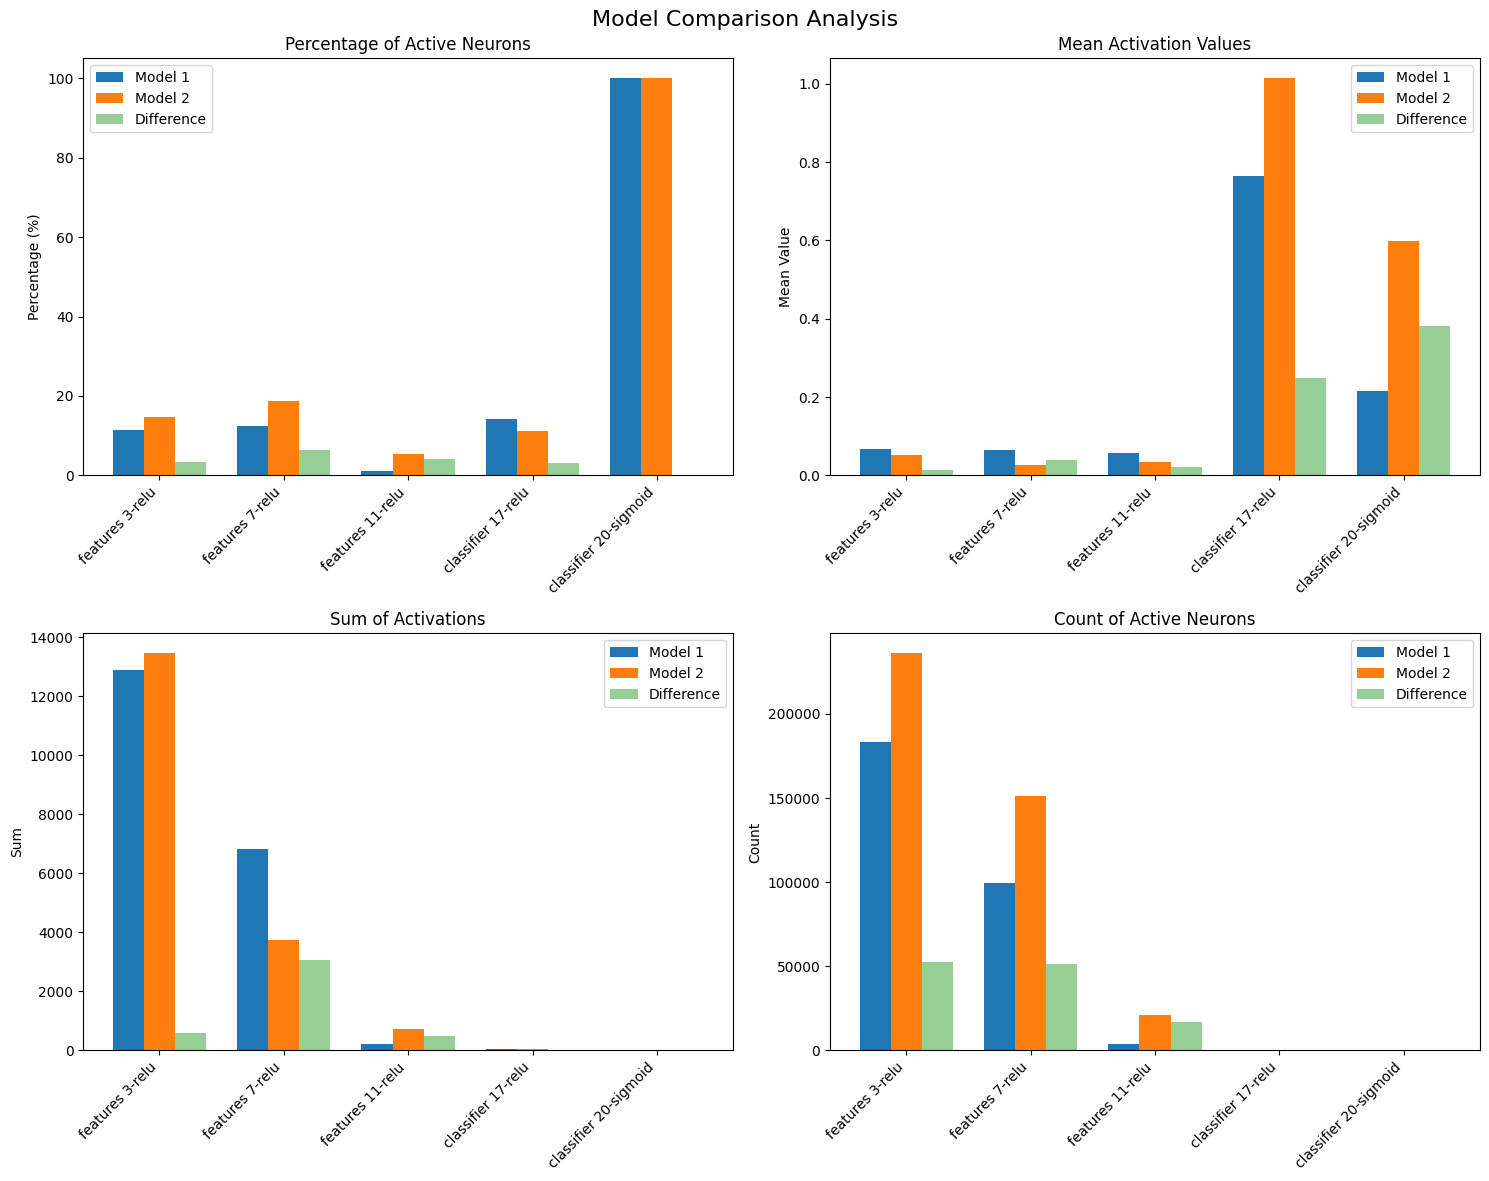


Numerical Differences (Model 2 - Model 1):

Layer: features 3-relu
Percentage Active Difference: 3.29%
Mean Activation Difference: -0.0139
Sum Activation Difference: 584.35
Active Neuron Count Difference: 52847

Layer: features 7-relu
Percentage Active Difference: 6.40%
Mean Activation Difference: -0.0402
Sum Activation Difference: -3080.61
Active Neuron Count Difference: 51386

Layer: features 11-relu
Percentage Active Difference: 4.26%
Mean Activation Difference: -0.0211
Sum Activation Difference: 488.71
Active Neuron Count Difference: 17114

Layer: classifier 17-relu
Percentage Active Difference: -3.03%
Mean Activation Difference: 0.2497
Sum Activation Difference: 6.70
Active Neuron Count Difference: -15

Layer: classifier 20-sigmoid
Percentage Active Difference: 0.00%
Mean Activation Difference: 0.3825
Sum Activation Difference: 0.38
Active Neuron Count Difference: 0


In [21]:
df = pd.read_csv('model_comparison_stats.csv')
layer_order = [
    'features 3-relu',
    'features 7-relu', 
    'features 11-relu',
    'classifier 17-relu',
    'classifier 20-sigmoid'
]
grouped = df.groupby('layer_name').mean().reindex(layer_order)

# Create a more readable format of the grouped data
print("\nGrouped Statistics by Layer:")
print("=" * 100)
print(grouped[['percentage_active_Model_1', 'percentage_active_Model_2', 
               'mean_Model_1', 'mean_Model_2',
               'sum_Model_1', 'sum_Model_2',
               'count_Model_1', 'count_Model_2']].round(4))

# Prepare the data
layers = grouped.index
width = 0.25

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Comparison Analysis', fontsize=16)

# 1. Percentage of Active Neurons
ax1 = axes[0, 0]
x = np.arange(len(layers))
ax1.bar(x - width, grouped['percentage_active_Model_1'], width, label='Model 1')
ax1.bar(x, grouped['percentage_active_Model_2'], width, label='Model 2')
ax1.bar(x + width, abs(grouped['percentage_active_Model_2'] - grouped['percentage_active_Model_1']), 
        width, label='Difference', alpha=0.5)
ax1.set_xticks(x)
ax1.set_xticklabels(layers, rotation=45, ha='right')
ax1.set_title('Percentage of Active Neurons')
ax1.set_ylabel('Percentage (%)')
ax1.legend()

# 2. Mean Activation Values
ax2 = axes[0, 1]
ax2.bar(x - width, grouped['mean_Model_1'], width, label='Model 1')
ax2.bar(x, grouped['mean_Model_2'], width, label='Model 2')
ax2.bar(x + width, abs(grouped['mean_Model_2'] - grouped['mean_Model_1']), 
        width, label='Difference', alpha=0.5)
ax2.set_xticks(x)
ax2.set_xticklabels(layers, rotation=45, ha='right')
ax2.set_title('Mean Activation Values')
ax2.set_ylabel('Mean Value')
ax2.legend()

# 3. Sum of Activations
ax3 = axes[1, 0]
ax3.bar(x - width, grouped['sum_Model_1'], width, label='Model 1')
ax3.bar(x, grouped['sum_Model_2'], width, label='Model 2')
ax3.bar(x + width, abs(grouped['sum_Model_2'] - grouped['sum_Model_1']), 
        width, label='Difference', alpha=0.5)
ax3.set_xticks(x)
ax3.set_xticklabels(layers, rotation=45, ha='right')
ax3.set_title('Sum of Activations')
ax3.set_ylabel('Sum')
ax3.legend()

# 4. Count of Active Neurons
ax4 = axes[1, 1]
ax4.bar(x - width, grouped['count_Model_1'], width, label='Model 1')
ax4.bar(x, grouped['count_Model_2'], width, label='Model 2')
ax4.bar(x + width, abs(grouped['count_Model_2'] - grouped['count_Model_1']), 
        width, label='Difference', alpha=0.5)
ax4.set_xticks(x)
ax4.set_xticklabels(layers, rotation=45, ha='right')
ax4.set_title('Count of Active Neurons')
ax4.set_ylabel('Count')
ax4.legend()

plt.tight_layout()
plt.show()

# Print numerical differences
print("\nNumerical Differences (Model 2 - Model 1):")
print("=" * 80)
for layer in layers:
    print(f"\nLayer: {layer}")
    print(f"Percentage Active Difference: {grouped['percentage_active_Model_2'][layer] - grouped['percentage_active_Model_1'][layer]:.2f}%")
    print(f"Mean Activation Difference: {grouped['mean_Model_2'][layer] - grouped['mean_Model_1'][layer]:.4f}")
    print(f"Sum Activation Difference: {grouped['sum_Model_2'][layer] - grouped['sum_Model_1'][layer]:.2f}")
    print(f"Active Neuron Count Difference: {grouped['count_Model_2'][layer] - grouped['count_Model_1'][layer]:.0f}")
